In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from mcap.reader import make_reader

In [4]:
mcap_path = Path("/data/strider/mcaps/2024-05-04/2024-05-04_15-51-47_0.mcap")

reader = make_reader(mcap_path.open("rb"))
topics = [v.topic for _,v in reader.get_summary().channels.items()]
topics

['/nw/perception/front_camera/stereo/image_compressed',
 '/zed/front_camera/right/camera_info',
 '/zed/front_camera/imu/data',
 '/zed/front_camera/left/camera_info',
 '/zed/front_camera/left_cam_imu_transform']

In [37]:
import h264decoder
import numpy as np
import psutil
import time

process = psutil.Process()
print("Memory usage before loop: {} MB".format(process.memory_info().rss / 1e6))

decoder = h264decoder.H264Decoder()

start_time = time.time()
num_frames = 0
last_time = 0
for i, (schema, channel, msg) in enumerate(reader.iter_messages(topics=topics[0])):
    if i > 100:
        break
    framedatas = decoder.decode(msg.data)
    if len(framedatas) > 1:
        print("Hold up!")
        break
    for framedata in framedatas:
        (frame, w, h, ls) = framedata
        if frame is not None:
            # Skip frames that are too close together
            time_diff = (msg.publish_time - last_time) / 1e9
            if time_diff < 5:
                # print("Skipping!")
                continue
            else:
                print("Found one!")
                last_time = msg.publish_time
                
            frame = np.frombuffer(frame, dtype=np.ubyte, count=len(frame))
            frame = frame.reshape((h, ls//3, 3))
            frame = frame[:,:w,:]
            num_frames += 1

print("Memory usage after loop: {} MB".format(process.memory_info().rss / 1e6))
print(f"Num iterations {i} : Num Frames {num_frames}")
print("Total time:", int(time.time() - start_time))

Memory usage before loop: 349.208576 MB
Found one!


[swscaler @ 0xaaaafc4d1030] No accelerated colorspace conversion found from yuv420p to rgb24.


Found one!
Memory usage after loop: 349.208576 MB
Num iterations 101 : Num Frames 2
Total time: 2


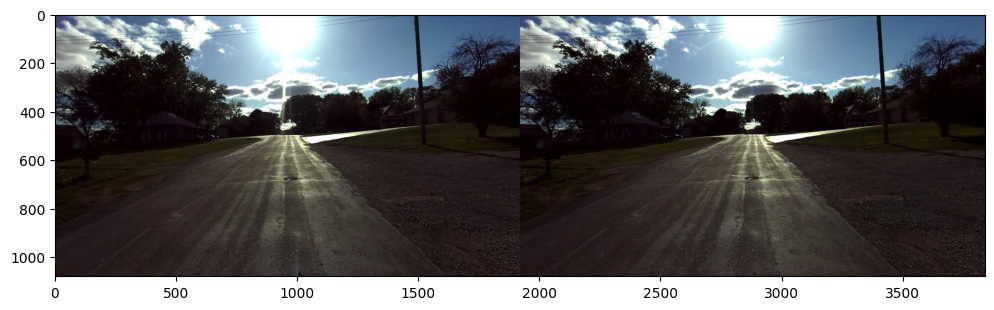

In [24]:
plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.show()

In [69]:
import ffmpeg
import numpy as np

HEIGHT = 1080
WIDTH = 1920
NUM_FRAMES = 50  # Number of frames to process
KEEP_TIME_DELTA = 1 / 2 # Every 0.5 seconds

# Configure FFmpeg to suppress output text
ffmpeg_args = {'loglevel': 'quiet', 'hide_banner': None}

# Initialize FFmpeg input and output buffers outside the loop
input_buffer = ffmpeg.input('pipe:', format='h264')
output_buffer = (
    ffmpeg.output(input_buffer, 'pipe:', format='rawvideo', pix_fmt='rgb24', **ffmpeg_args)
    .global_args('-loglevel', 'error')
)

batch_frames = []
batch_times = []
left_frames = []
right_frames = []
last_time = 0
last_byte_string = b''
byte_string = b''
last_img_size = 0
processed_batches = 0
for i, (schema, channel, msg) in enumerate(reader.iter_messages(topics=topics[0])):
    if processed_batches > 5:
        break

    byte_string = msg.data[:5]
    # img_size = len(msg.data) / 1e6
    if byte_string == last_byte_string or i == 0:
    # if img_size < 0.5 or i == 0:
        # print the size of the message in MB
        print(f"[ {i} ] Message size: {len(msg.data) / 1e6:.2f} MB -", msg.data[:10])
        batch_frames.append(msg.data)
        batch_times.append(msg.publish_time)
        last_byte_string = byte_string
        continue
    
    print("------ Processing batch {} ------".format(processed_batches))
    # Decode the frame using FFmpeg
    out, _ = ffmpeg.run(output_buffer, capture_stdout=True, input=b''.join(batch_frames))
    
    # Convert the output buffer to a numpy array
    decoded_frame = np.frombuffer(out, np.uint8).reshape(-1, HEIGHT, WIDTH * 2, 3)

    # Determine keep indices
    keep_indices = []
    for j, t in enumerate(batch_times):
        if ((t - last_time) / 1e9 ) > KEEP_TIME_DELTA and j < len(decoded_frame):
            keep_indices.append(j)
            last_time = t
    decoded_frame = decoded_frame[keep_indices]
    
    # Break into left and right frames
    left_frame = decoded_frame[:, :, :WIDTH, :]
    right_frame = decoded_frame[:, :, WIDTH:, :]
    
    # Process the left and right frames as needed
    # ...
    left_frames.extend(left_frame)
    right_frames.extend(right_frame)

    batch_frames = [msg.data]
    batch_times = [msg.publish_time]
    last_byte_string = byte_string
    processed_batches += 1

[ 0 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xe9\x9f6f\x00\x05'
[ 1 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xe9\x9f6f\xb0\xbd'
[ 2 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xe9\x9f6f\xd0\t'
[ 3 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xe9\x9f6f\x10\xb7'
[ 4 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xe9\x9f6f@\x1e'
[ 5 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xe9\x9f6f\xd0\x8e'
[ 6 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xe9\x9f6f\xb8\x0e'
[ 7 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xe9\x9f6f0\x83'
[ 8 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xe9\x9f6f\x18z'
[ 9 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xe9\x9f6f\xf8\xad'
------ Processing batch 0 ------
[ 11 ] Message size: 0.30 MB - b'\x00\x01\x00\x00\xea\x9f6f\xc8l'
[ 12 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xea\x9f6f01'
[ 13 ] Message size: 0.26 MB - b'\x00\x01\x00\x00\xea\x9f6f\xc0\x0c'
[ 14 ] Message size: 0.26 MB - b'\x00\x01\x00\x00\xea\x9f6f\x00\xc0'
[ 15 ] Message size: 0.52 MB - 

[h264 @ 0x13a714440] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x13a714440] decode_slice_header error
[h264 @ 0x13a714440] no frame!


[ 38 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xec\x9f6f\x80a'
[ 39 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xec\x9f6fX\xc6'
[ 40 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xec\x9f6fx\r'
[ 41 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xec\x9f6f\x18('
[ 42 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xec\x9f6f\xf8\xcc'
[ 43 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xec\x9f6f\x90\x89'
[ 44 ] Message size: 0.27 MB - b'\x00\x01\x00\x00\xec\x9f6fX\x0e'
[ 45 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xec\x9f6f\xc8Z'
[ 46 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xec\x9f6f\x10\xd7'
[ 47 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xec\x9f6fH\x9c'
[ 48 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xec\x9f6fh\xe9'
[ 49 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xec\x9f6f@\xcb'
------ Processing batch 3 ------


[h264 @ 0x126e373f0] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x126e373f0] decode_slice_header error
[h264 @ 0x126e373f0] no frame!
[h264 @ 0x126e373f0] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x126e373f0] decode_slice_header error
[h264 @ 0x126e373f0] no frame!
[h264 @ 0x126e373f0] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x126e373f0] decode_slice_header error
[h264 @ 0x126e373f0] no frame!


[ 51 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xed\x9f6f\x98\xa3'
[ 52 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xed\x9f6f\xb8m'
[ 53 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6fxM'
[ 54 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6fx:'
[ 55 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xed\x9f6f\xf0='
[ 56 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6f\x98\x8c'
[ 57 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6f\x80\x83'
[ 58 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6f >'
[ 59 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6fh+'
[ 60 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xed\x9f6f\x18\xe4'
[ 61 ] Message size: 0.29 MB - b'\x00\x01\x00\x00\xed\x9f6f\xb8\xb0'
[ 62 ] Message size: 0.28 MB - b'\x00\x01\x00\x00\xed\x9f6fP\x9c'
------ Processing batch 4 ------
[ 64 ] Message size: 0.27 MB - b'\x00\x01\x00\x00\xee\x9f6f\xb8\xe2'
[ 65 ] Message size: 0.52 MB - b'\x00\x01\x00\x00\xee\x9f6fpv'
[ 66 ] Message size: 0.30 MB - b'\x00\x0

[h264 @ 0x12b917400] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x12b917400] decode_slice_header error
[h264 @ 0x12b917400] no frame!
[h264 @ 0x12b917400] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x12b917400] decode_slice_header error
[h264 @ 0x12b917400] no frame!


In [68]:
len(left_frames), len(right_frames), processed_batches, i

(133, 133, 76, 1032)

In [53]:
# img_idx = np.random.choice(len(left_frames))
img_idx = 0
print(f"Displaying frame {img_idx}")
lf = left_frames[img_idx]
rf = right_frames[img_idx]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(lf)
axs[1].imshow(rf)

plt.show()

Displaying frame 0


IndexError: list index out of range

In [155]:
# Get memory size of left and right frames
left_size = sum(f.nbytes for f in left_frames)
right_size = sum(f.nbytes for f in right_frames)

# Get the final memory usage
final_memory = process.memory_info().rss

# Calculate the memory usage of the frames in MB
left_memory = left_size / 1024 / 1024
right_memory = right_size / 1024 / 1024

left_memory, right_memory

(403.41796875, 403.41796875)

In [142]:
# Helper function to find the NAL unit start code
def find_nal_unit_start_code(data):
    return data.find(b'\x00\x00\x01') != -1 or data.find(b'\x00\x00\x00\x01') != -1

# Helper function to check if a NAL unit is an I-frame
def is_i_frame(nal_unit_type):
    return nal_unit_type in [5, 7]  # IDR_W_RADL or IDR_N_LP

def process_batch(batch_frames):
    # Decode the frame using FFmpeg
    out, _ = ffmpeg.run(output_buffer, capture_stdout=True, input=b''.join(batch_frames))
    
    # Convert the output buffer to a numpy array
    decoded_frame = np.frombuffer(out, np.uint8).reshape(-1, HEIGHT, WIDTH * 2, 3)
    
    # Process the decoded frame as needed
    # ...
    left_frames = decoded_frame[:, :, :WIDTH, :]
    right_frames = decoded_frame[:, :, WIDTH:, :]

    return left_frames, right_frames

# Iterate through the ROS2 topic messages
batch_frames = []
left_frames = []
right_frames = []
for i, (schema, channel, msg) in enumerate(reader.iter_messages(topics=topics[0])):
    encoded_frame = msg.data
    
    # Find the NAL unit start code
    start_code_pos = find_nal_unit_start_code(encoded_frame)
    
    if start_code_pos != -1:
        # Extract the NAL unit type
        nal_unit_type = encoded_frame[start_code_pos + 3] & 0x1F
        
        # Check if the NAL unit is an I-frame
        if is_i_frame(nal_unit_type):
            print(f"Found I-frame at index {i}")
            # Process the previous batch of frames
            if batch_frames:
                lfs, rfs = process_batch(batch_frames)
                left_frames.extend(lfs)
                right_frames.extend(rfs)
                batch_frames = []
            
            # Start a new batch with the current I-frame
            batch_frames.append(encoded_frame)
        else:
            # Add the frame to the current batch
            batch_frames.append(encoded_frame)

# Process the last batch of frames
if batch_frames:
    lfs, rfs = process_batch(batch_frames)
    left_frames.extend(lfs)
    right_frames.extend(rfs)
    

Found I-frame at index 366
Found I-frame at index 367


[h264 @ 0x133f22220] non-existing PPS 0 referenced
    Last message repeated 1 times
[h264 @ 0x133f22220] decode_slice_header error
[h264 @ 0x133f22220] no frame!
[h264 @ 0x133e2acc0] non-existing PPS 0 referenced
[h264 @ 0x133e2acc0] decode_slice_header error
[h264 @ 0x133e2acc0] no frame!
[vist#0:0/h264 @ 0x133e26f80] Decoding error: Invalid data found when processing input
Cannot determine format of input stream 0:0 after EOF
Error marking filters as finished
Error while filtering: Invalid data found when processing input
[vist#0:0/h264 @ 0x133e26f80] Decode error rate 1 exceeds maximum 0.666667
[out#0/rawvideo @ 0x133e23fc0] Nothing was written into output file, because at least one of its streams received no packets.


Error: ffmpeg error (see stderr output for detail)